Dataset shape: (7298, 31)
is_all_star
0    7148
1     150
Name: count, dtype: int64

✅ Model Training Complete!
Final Accuracy: 0.99
Final ROC-AUC: 1.00

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1430
           1       0.76      0.83      0.79        30

    accuracy                           0.99      1460
   macro avg       0.88      0.91      0.89      1460
weighted avg       0.99      0.99      0.99      1460



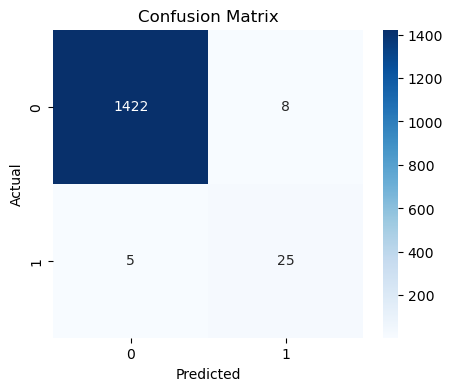

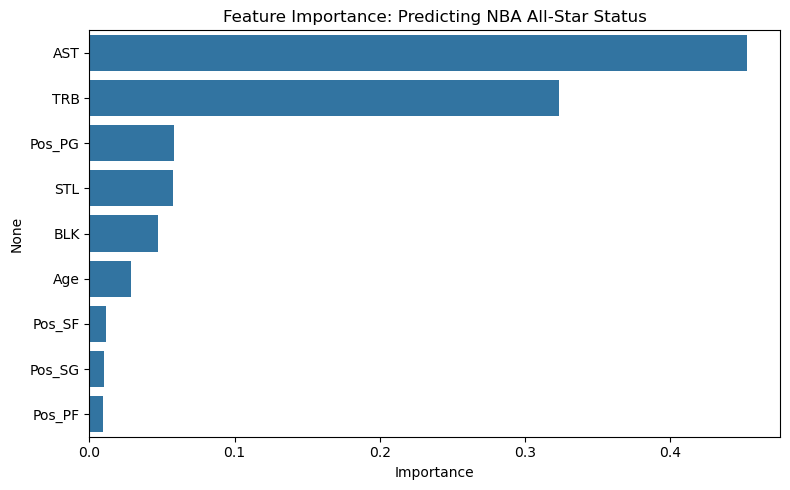

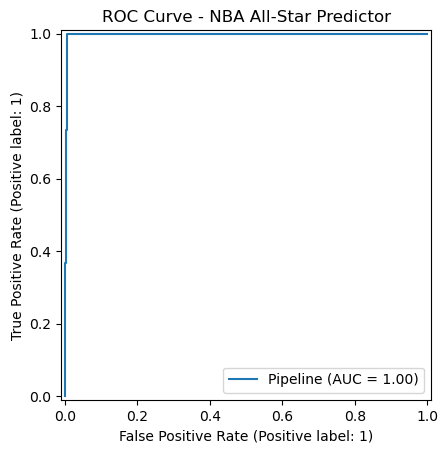

In [67]:
# 📊 NBA All-Star Predictor (Clean Version)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
)

# --- Load Dataset ---
df = pd.read_csv('/Users/yusufshire/Downloads/NBA Player Stats and Salaries_2010-2025 2.csv')
print("Dataset shape:", df.shape)

# --- Drop rows with missing key stats ---
df = df.dropna(subset=['PTS', 'AST', 'TRB', 'STL', 'BLK', 'Pos', 'Age'])

# --- Ensure numeric columns are numeric ---
for col in ['PTS', 'AST', 'TRB', 'STL', 'BLK', 'Age']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# --- Clean hybrid positions like 'SF-C' → 'SF' ---
df['Pos'] = df['Pos'].astype(str).str.split('-').str[0]

# --- Create target variable ---
df['is_all_star'] = np.where(
    (df['PTS'] >= 18) & (df['AST'] >= 5) & (df['TRB'] >= 5),
    1, 0
)

print(df['is_all_star'].value_counts())

# --- Feature selection ---
features = ['AST', 'TRB', 'STL', 'BLK', 'Pos', 'Age']
X = df[features]
y = df['is_all_star']

# --- Define transformers ---
numeric_features = ['AST', 'TRB', 'STL', 'BLK', 'Age']
categorical_features = ['Pos']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# --- Combine preprocessing ---
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# --- Split data ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Build model pipeline ---
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=200, max_depth=5, random_state=42))
])

# --- Train model ---
rf_model.fit(X_train, y_train)

# --- Predictions ---
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]

# --- Evaluation ---
acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_proba)

print(f"\n✅ Model Training Complete!")
print(f"Final Accuracy: {acc:.2f}")
print(f"Final ROC-AUC: {roc:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# --- Confusion Matrix ---
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# --- Feature Importance ---
model = rf_model.named_steps['classifier']
ohe_features = rf_model.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder'].get_feature_names_out(categorical_features)
all_features = numeric_features + list(ohe_features)

importances = pd.Series(model.feature_importances_, index=all_features).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=importances.index)
plt.title('Feature Importance: Predicting NBA All-Star Status')
plt.xlabel('Importance')
plt.tight_layout()
plt.savefig('Feature_importance.png', bbox_inches='tight')
plt.show()

# --- ROC Curve ---
RocCurveDisplay.from_estimator(rf_model, X_test, y_test)
plt.title('ROC Curve - NBA All-Star Predictor')
plt.show()
